In [1]:
import math
import random
import decimal
import scipy.linalg
import numpy.random as nrand
import matplotlib.pyplot as plt
import gpflow
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

C:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Anaconda\lib\site-packages\multipledispatch\dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Identity, NoneType, Kernel, InducingPoints], [Gaussian, Linear, NoneType, Sum, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


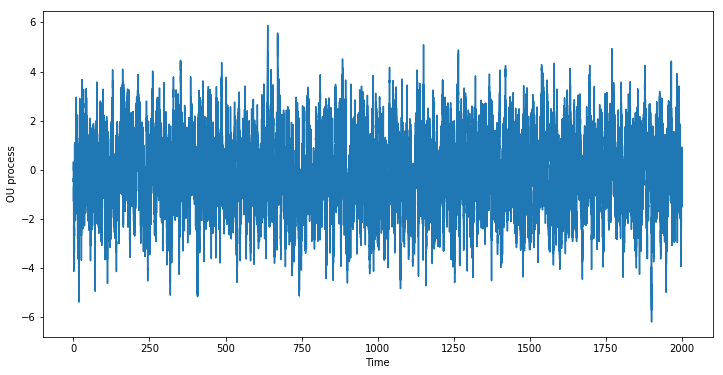

In [2]:
# check for a match
def ou_values(a,b,dt,sigma,time):
    #This method returns the rate levels of a mean-reverting ornstein uhlenbeck process.
    x = np.zeros(len(time))
    for i in range(0, len(time)-1):
        x[i+1]=x[i]+a*(b-x[i])*dt+math.sqrt(dt)*sigma*np.random.normal(0,1)
    return x
dt=0.01
total_time=2000
time=np.arange(0,total_time+dt,dt)# time
sigma=2
a=1# the coefficient in front, the rate
b=0# the mean
#Simulation of an OU process
x=ou_values(a,b,dt,sigma,time)# the first one is zero because param_all_r0 starts at 0
t=time# time vector
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('OU process')
plt.show()

In [3]:
skip=100
t_column=t[::skip]
x_column=x[::skip]
t_column=t_column.reshape(-1,1)
x_column=x_column.reshape(-1,1)
k = gpflow.kernels.Matern12(1,lengthscales=1,variance=1)
m = gpflow.models.GPR(t_column,x_column,kern=k)
m.likelihood.variance = 0.0# observation noise


Text(0,0.5,'OU level')

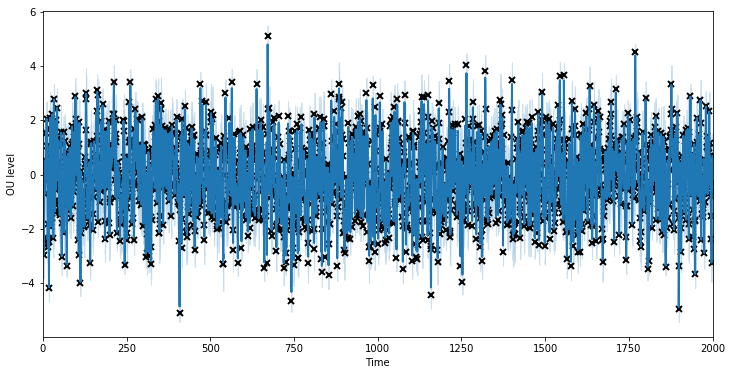

In [4]:
tt = np.linspace(0, total_time, 10000).reshape(10000, 1)
mean, var = m.predict_y(tt)
plt.figure(figsize=(12, 6))
plt.plot(t_column,x_column, 'kx', mew=2)
plt.plot(tt, mean, 'C0', lw=2)
plt.fill_between(tt[:,0],
                 mean[:,0] - 2*np.sqrt(var[:,0]),
                 mean[:,0] + 2*np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)
plt.xlim(0, total_time)


plt.xlabel('Time')
plt.ylabel('OU level')

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 3384.820107
  Number of iterations: 7
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 3384.820107
  Number of iterations: 7
  Number of functions evaluations: 8


                             class prior transform  trainable shape  \
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                   value  
GPR/kern/variance               True       2.018945267720672  
GPR/kern/lengthscales           True      1.0380840137335536  
GPR/likelihood/variance         True  1.0000000002220446e-06  


Text(0,0.5,'OU level')

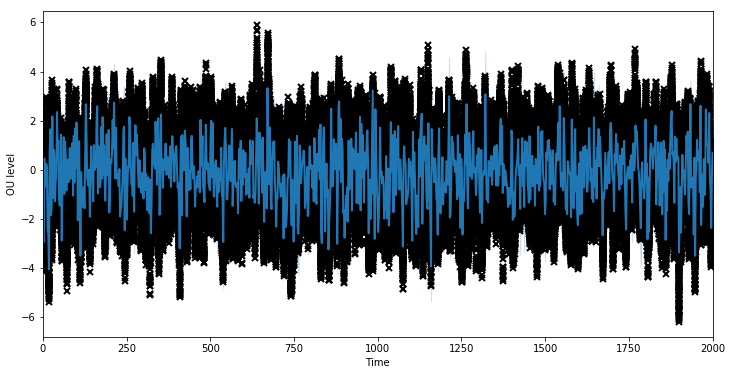

In [6]:
gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())

tt = np.linspace(0, total_time, 1000).reshape(1000, 1)
mean, var = m.predict_y(tt)
plt.figure(figsize=(12, 6))
plt.plot(t,x, 'kx', mew=2)
plt.plot(tt, mean, 'C0', lw=2)
plt.fill_between(tt[:,0],
                 mean[:,0] - 2*np.sqrt(var[:,0]),
                 mean[:,0] + 2*np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)
plt.xlim(0, total_time)


plt.xlabel('Time')
plt.ylabel('OU level')

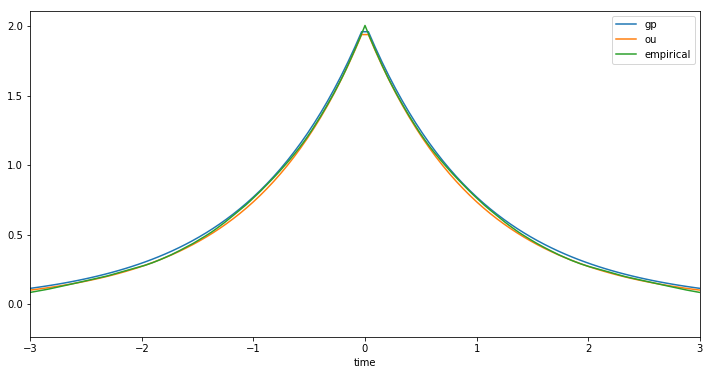

In [7]:
#Comparison to analytical covariance function
xmin=-3
xmax=3
xx = np.linspace(xmin, xmax, 100)[:,None]

k= m.kern# gpflow.kernels.Matern12(1,lengthscales=1,variance=sigma**2/(2.0*a))
plt.plot(xx, k.compute_K(xx, np.zeros((1,1))),label='gp')
#plt.figure()
f = sigma**2/(2*a)*np.exp(-np.abs(xx)*a)
plt.plot(xx, f,label='ou')

yunbiased = x-np.mean(x)# x is the ou values
acor = np.correlate(yunbiased, yunbiased, "same")*np.var(yunbiased)/np.sum(yunbiased**2)
plt.plot(dt*np.arange(-(len(acor)-1)//2,(len(acor)+1)//2),acor,label='empirical')
plt.xlim(-3,3)
plt.legend()
plt.xlabel('time')
plt.show()